In [1]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 3.9 MB/s 


In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import random 
from tensorflow import keras
from torchvision import transforms
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd '/content/gdrive/My Drive/CV_Project/'

/content/gdrive/My Drive/CV_Project


In [5]:
DIR = '/content/gdrive/My Drive/CV_Project/'
all_img_dirs = os.listdir(DIR+'Useful_Images/new_Images')
X = []
y = []
temp = []
label_id = []

for i in all_img_dirs:
  X.append(cv2.imread(DIR+'Useful_Images/new_Images'+'/'+i))
  if 'elk' in i.lower():
    temp.append(0)
    y.append(temp)
    temp = []
    label_id.append(0)
  else:
    temp.append(1)
    y.append(temp)
    temp = []
    label_id.append(1)

In [39]:
num_classes = 2
input_shape = (256, 256, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 200
image_size = 72  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [40]:
(x_train, x_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=42)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [41]:
x_train.shape, x_test.shape 

((3884, 256, 256, 3), (972, 256, 256, 3))

In [42]:
# Data Augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(x_train)


# Multilayer perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Create Patches as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Linearly transform a patch by projecting it into a vector of size 'projection_dim'
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Image size: 72 X 72
Patch size: 8 X 8
Patches per image: 81
Elements per patch: 192


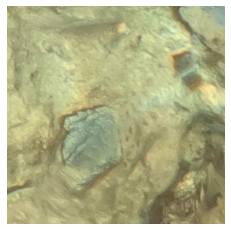

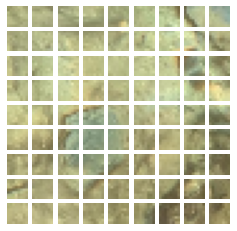

In [43]:
# Sample Patched Image
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [44]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs) # Augment Images
    patches = Patches(patch_size)(augmented) # Create patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches) #Encode patches

    # Create multiple layers of the Transformer Encoder block
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches) # Layer normalization 1
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)  # Create a multi-head attention layer
        x2 = layers.Add()([attention_output, encoded_patches]) # Skip connection 1
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2) # Layer normalization 2
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1) # Multi Layer Perceptron
        encoded_patches = layers.Add()([x3, x2]) # Skip connection 2

    # Create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5) # Add Multi Layer Perceptron
    logits = layers.Dense(num_classes)(features) # Classify outputs 
    model = keras.Model(inputs=inputs, outputs=logits) # Create the Keras model
    return model


def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ) # AdamW Optimizer

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.15,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [45]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/200
13/13 [==============================] - 15s 447ms/step - loss: 2.8569 - accuracy: 0.5232 - top-5-accuracy: 1.0000 - val_loss: 0.8529 - val_accuracy: 0.4391 - val_top-5-accuracy: 1.0000
Epoch 2/200
13/13 [==============================] - 5s 352ms/step - loss: 0.7436 - accuracy: 0.5998 - top-5-accuracy: 1.0000 - val_loss: 0.6509 - val_accuracy: 0.6175 - val_top-5-accuracy: 1.0000
Epoch 3/200
13/13 [==============================] - 5s 358ms/step - loss: 0.6258 - accuracy: 0.6495 - top-5-accuracy: 1.0000 - val_loss: 0.5703 - val_accuracy: 0.7187 - val_top-5-accuracy: 1.0000
Epoch 4/200
13/13 [==============================] - 4s 314ms/step - loss: 0.5833 - accuracy: 0.6910 - top-5-accuracy: 1.0000 - val_loss: 0.5489 - val_accuracy: 0.7187 - val_top-5-accuracy: 1.0000
Epoch 5/200
13/13 [==============================] - 5s 356ms/step - loss: 0.5421 - accuracy: 0.7204 - top-5-accuracy: 1.0000 - val_loss: 0.4904 - val_accuracy: 0.7684 - val_top-5-accuracy: 1.0000
Epoch 6/200
13

In [46]:
vit_classifier.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_4[0][0]']                
                                                                                                  
 patches_7 (Patches)            (None, None, 192)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder_3 (PatchEncoder)  (None, 81, 64)      17536       ['patches_7[0][0]']        

31/31 [==============================] - 1s 17ms/step


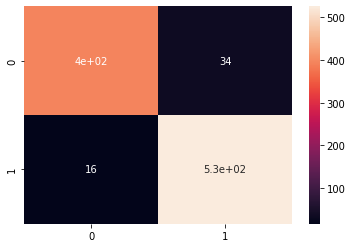

In [47]:
prediction = vit_classifier.predict(x_test)
pred = np.array(np.argmax(prediction, axis = 1))
tmp = []
y_pred = []
for i in pred:
  tmp.append(i)
  y_pred.append(tmp)
  tmp = []

# Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)

In [48]:
print("Lengths of labels for both predicted and True Test Images", len(y_pred), len(y_test))
print(pred[0], y_test[0])
print(pred[187], y_test[187])
print(pred[221], y_test[221])
print(pred[65], y_test[65])
print(pred[757], y_test[757]) 
print(pred[32], y_test[32])

Lengths of labels for both predicted and True Test Images 972 972
0 [1]
0 [0]
1 [1]
1 [1]
0 [0]
1 [1]


In [49]:
classification_report(y_test,y_pred)

'              precision    recall  f1-score   support\n\n           0       0.96      0.92      0.94       430\n           1       0.94      0.97      0.95       542\n\n    accuracy                           0.95       972\n   macro avg       0.95      0.95      0.95       972\nweighted avg       0.95      0.95      0.95       972\n'